# Attack attempt, training both G and D in the GAN

First attempt at training the GAN D/G to provide **valid** and **representable** data from unknown classes

## Imports

In [1]:
import tensorflow as tf
# tf.enable_eager_execution() # default for TF 2.0

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
# import keras.backend as K
from tensorflow.keras.datasets import mnist

print('TF', tf.__version__)
print('Keras', keras.__version__)

TF 2.1.0
Keras 2.2.4-tf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle
from glob import glob

import os.path
import shutil
import math
import random
from copy import copy

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.random.set_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# EASY_MODE: if True, Split Learning NN is used as the Discriminator in the GAN. This is good for testing, but
# bypasses the black-box paradigm! Use with caution
EASY_MODE = True

# Black-box params (optimized for MNIST)
best_depth = 9
best_filters = 33
best_dense = 110

# GAN params
gan_epochs = 10 # 25
gan_batch_size = 256 # 60
noise_dim = 100
attack_class = 1

# Split Learning params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets

# split_batch_size = 256                          # number of clients to train on at once
split_minibatch_size = None                     # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
split_batches_per_train_step = 20               # after averaging the gradients from X clients, we will apply them to the model
split_epochs = 25
shuffle_clients = True
split_num_classes = 10
split_eval_batch_size = 256 # 60

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

In [5]:
# setup checkpoint folders
blackbox_checkpoint_folder = "blackbox_checkpoint"
discriminator_checkpoint_folder = "discriminator_checkpoint"
generator_checkpoint_folder = "generator_checkpoint"

## Load Data

In [6]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
# x_train /= 255    # range is [0, 1]
x_test = (x_test - 127.5) / 127.5 # Normalize the images to [-1, 1]
# x_test /= 255     # range is [0, 1]

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, split_num_classes)
y_test = keras.utils.to_categorical(y_test, split_num_classes)

In [7]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

BUFFER_SIZE = x_train.shape[0]

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [8]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


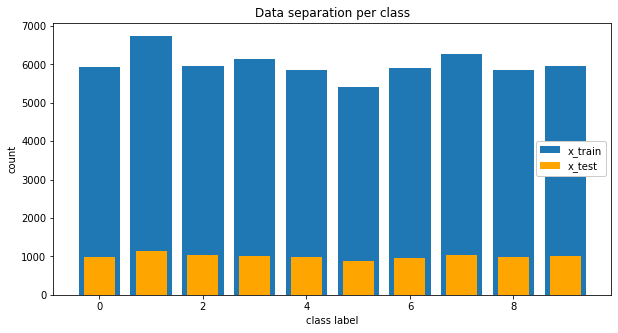

In [9]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

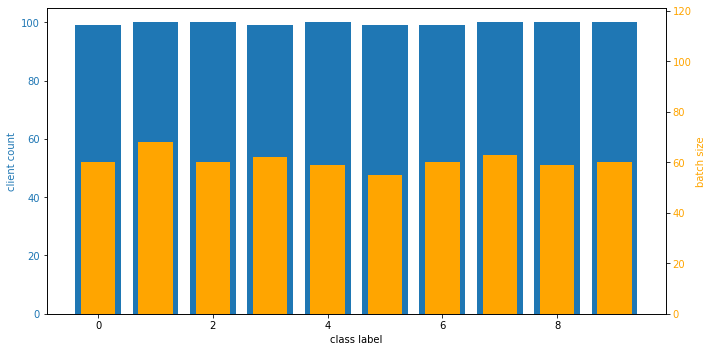

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [10]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

split_batch_size = np.floor(np.mean([v for v in batch_sizes.values()]))

#### Batch and shuffle automatically

In [11]:
# Batch and shuffle the data for GAN
gan_train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(gan_batch_size)

In [12]:
# Batch and shuffle the data for Split Learning
split_train_dataset = (x_batches, y_batches)
split_test_dataset = (x_test, y_test)

## Build Model

In [13]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece_(input_shape, filters=4):
    assert filters >= 1
    
    model = tf.keras.Sequential()
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    return model

def blackbox_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same'))
    
    return model

def approximator_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
    model = blackbox_piece_(model, depth, filters)
    
    return model

def end_piece_(model, dense_breadth=128, num_classes=10):
    assert dense_breadth >= num_classes
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(dense_breadth, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

## Graph Creation

In [14]:
class SplitLearning:
    
    def __init__(self, input_shape, depth, filters, dense, minibatch_size, batches_per_train_step, num_classes=10,
                 eval_batch_size=256):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.minibatch_size = minibatch_size
        self.num_classes = num_classes
        self.eval_batch_size = eval_batch_size
        self.iteration = 0
        
        self.batches_per_train_step = batches_per_train_step
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.model = self.split_model(input_shape, depth, filters, dense)
        
        # define loss function
        self.cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=True)
        
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define metrics
        self.acc_train_avg = None
        self.loss_train_avg = None
        
        # setup checkpointing
        self.ckpt = None
        self.init_ckpt()
        self.manager = None
        self.internal_iteration = None
        self.iteration_offset = 0
        
        # setup ops
        self.setup_ops()
        
    ###########################################################################################
    # Black-box model
        
    def split_model(self, input_shape, depth=1, filters=4, dense_breadth=128):
        assert depth >= 1
        assert filters >= 1
        assert dense_breadth >= self.num_classes

        model = start_piece_(input_shape, filters)
        model = blackbox_piece_(model, depth, filters)
        model = end_piece_(model, dense_breadth, self.num_classes)

        return model
    
    def model_loss(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
        
    ###########################################################################################
    # Train
    
    def setup_ops(self):
        # INSPIRED BY: https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients
        # https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
        
        self.tvs = self.model.trainable_variables
        self.accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in self.tvs]
        self.accum_counter = tf.Variable(0.0, trainable=False)
    
    def train(self, dataset, iteration):
        # setup checkpointing
        self.setup_ckpt(iteration)
        
        # initialize the metrics each new epoch
        if self.acc_train_avg is not None:
            del self.acc_train_avg
        if self.loss_train_avg is not None:
            del self.loss_train_avg
        self.acc_train_avg = tf.keras.metrics.Accuracy()
        self.loss_train_avg = tf.keras.metrics.Mean()
        
        x_batches, y_batches = dataset
        pbar = tqdm_notebook(total=len(x_batches))
        
        batch_idxs = list(range(len(x_batches)))
        if shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)
            
        for i, batch_idx in enumerate(batch_idxs):
            x_batch = x_batches[batch_idx][1]
            y_batch = y_batches[batch_idx][1]
            
            self.train_step(i, x_batch, y_batch, len(batch_idxs) - 1)
            pbar.update(1)
            pbar.set_description('train_acc={:.2f}%'.format(self.acc_train_avg.result()*100))
        pbar.close()
        
        # save checkpoints
        self.checkpoint()
        
    def train_step(self, i, x_batch, y_batch, limit):
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
                y_minibatch = y_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                y_minibatch = y_batch[j:(j+self.minibatch_size)]

            # run the gradients
            loss_value, grads = self.grad(x_minibatch, y_minibatch)

            # accumulate them
            self.accumulate_grads(grads)

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size

        # perform a train step every batches_per_train_step number of batches:
        if (i > 0 and i % self.batches_per_train_step == 0) or i == limit:
            # Run the train_step ops to update the weights based on our accumulated gradients
            self.optimize()
            self.zero_out()
    
    def grad(self, inputs, targets):
        with tf.GradientTape() as tape:
            logits = self.model(inputs, training=True)
            loss_value = self.model_loss(targets, logits)
            
        # evaluate accuracy and append acc and loss to arrays
        self.acc_train_avg(tf.argmax(targets, 1), tf.argmax(logits, 1))
        self.loss_train_avg(loss_value)
        
        return loss_value, tape.gradient(loss_value, self.model.trainable_variables)
    
    def accumulate_grads(self, grads):
        # add to accum_vars the new gradients
        self.accum_vars = [self.accum_vars[i].assign_add(grad) for i, grad in enumerate(grads)]
        # increment the counter by 1
        self.accum_counter.assign_add(1.0)
        
    def optimize(self):
        # apply the gradients in accum_vars, dividing by the number in accum_counter
        self.optimizer.apply_gradients(
            [(accum_var / self.accum_counter, tv) \
                for (accum_var, tv) in zip(self.accum_vars, self.model.trainable_variables)]
        )
    
    def zero_out(self):
        # reset accum_vars and accum_counter back to 0
        self.accum_vars = [tv.assign(tf.zeros_like(tv)) for tv in self.accum_vars]
        self.accum_counter = tf.Variable(0.0, trainable=False)
        
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        # setup fresh checkpointer every new iteration
        if self.internal_iteration is None or iteration != self.internal_iteration - self.iteration_offset:
            ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration + self.iteration_offset), blackbox_checkpoint_folder)
            os.makedirs(ckpt_save_folder, exist_ok=True)
        
            if self.ckpt is not None:
                del self.ckpt
            if self.manager is not None:
                del self.manager

            self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
            self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
            self.internal_iteration = iteration + self.iteration_offset
    
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved checkpoint: {}".format(save_path))
        
    def restore(self, it=None, load_default=False):
        parent_folder = os.path.join('checkpoints')
        if it is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, blackbox_checkpoint_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    it = int(d.split('_')[1])
                    if largest_it is None or it > largest_it:
                        largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), blackbox_checkpoint_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', blackbox_checkpoint_folder)
                it = 0
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it), blackbox_checkpoint_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = it
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    ###########################################################################################
    # Evaluate
        
    def evaluate(self, dataset):
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.eval_batch_size):
            # get batch
            x_batch = x[i:i+self.eval_batch_size]
            y_batch = y[i:i+self.eval_batch_size]
            
            # evaluate
            logits = self.model(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.model_loss(y_batch, logits))
        
        if self.acc_train_avg is not None and self.loss_train_avg is not None:
            print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(self.acc_train_avg.result(), self.loss_train_avg.result()))
        print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()

In [15]:
class GAN:
    
    def __init__(self, attack_class, input_shape, depth, filters, dense, batch_size, noise_dim=100, num_classes=10,
                 discriminator=None):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.noise_dim = noise_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.attack_class = attack_class # the label index of the (unknown) class that we want to predict
        self.save_ckpts = True
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        if discriminator is not None:
            self.discriminator = discriminator
        else:
            self.discriminator = self.discriminator_model(input_shape, depth, filters, dense)
        self.generator = self.generator_model(noise_dim)
        
        # define loss function (TODO: change to MSE)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        # define optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # seed for image generation
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        
        # setup metrics (TODO)
        
        # setup checkpointing
        self.discriminator_ckpt = None
        self.discriminator_manager = None
        self.generator_ckpt = None
        self.generator_manager = None
        self.internal_iteration = None
        self.iteration_offset = 0
        self.init_ckpts()
        
    ###########################################################################################
    # Label matching
        
    def soft_onehot(self, softmax, my_power=8):
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
        
    def matches_label(self, fake_output, loop_times=3):
        '''
        Only works if the Discriminator is already trained on real images!!
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Multiplies this by the onehot version of the onehot attack label
        3. Sums to reduce dimension
        
        - if the sum is close to 1, the nn thinks that the image is a part of the attack class
        - if the sum is close to 0, the nn thinks that the image is not of the attack class
        - the sum should not be in between, due to the onehot conversion we perform in step 1
        '''
        # 1.
        my_power = 8
        for i in range(loop_times):
            fake_output = self.soft_onehot(fake_output)
        
        # 2.
        attack_indices = tf.one_hot(self.attack_class, self.num_classes, dtype=tf.dtypes.float32)
        matches = tf.math.multiply(fake_output, attack_indices)
        
        # 3.
        reduced = tf.math.reduce_sum(matches, axis=-1)
        
        return reduced
        
    def matches_label_simple(self, fake_output, loop_times=3):
        '''
        Simpler match, performs no softmax -> onehot conversion
        - if the sum is close to 1, the nn thinks that the image is a part of the attack class
        - if the sum is close to 0, the nn thinks that the image is not of the attack class
        - the sum can be between 0 and 1, depending upon the certainty of the nn
        '''
        # get softmax probs at attack_class index
        attack_indices = tf.one_hot(self.attack_class, self.num_classes, dtype=tf.dtypes.float32)
        matches = tf.math.multiply(fake_output, attack_indices)
        
        # sum to reduce (extract the softmax prob)
        reduced = tf.math.reduce_sum(matches, axis=-1)
        
        return reduced
        
    ###########################################################################################
    # Discriminator
    # - since we know the label
    
    def discriminator_model(self, input_shape, depth=1, filters=4, dense_breadth=128):
        assert depth >= 1
        assert filters >= 1
        assert dense_breadth >= self.num_classes

        model = start_piece_(input_shape, filters)
        model = approximator_piece_(model, depth, filters)
        model = end_piece_(model, dense_breadth, self.num_classes)

        return model
    
    def discriminator_loss(self, fake_discrimination):
        matches = self.matches_label(fake_discrimination, loop_times=10)
        # we want the discriminator to NOT be fooled by these fake images
        cross_entropy = self.cross_entropy(tf.zeros_like(matches), matches)
        return cross_entropy
    
    def discriminator_entropy(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
        
    ###########################################################################################
    # Generator

    def generator_model(self, noise_dim=100):
        model = tf.keras.Sequential()
        
        model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

        return model
    
#     def generator_loss(self, fake_discrimination):
#         matches = self.matches_label_simple(fake_discrimination)
#         # we want the discriminator to be fooled by these fake images
#         cross_entropy = self.cross_entropy(tf.ones_like(matches), matches)
#         return cross_entropy

    def generator_loss(self, fake_discrimination):
        # make a list of onehot vectors representing the attack class:
        attack_label = tf.one_hot(self.attack_class, self.num_classes, dtype=tf.dtypes.float32)
        
        # tile into the right dims (https://stackoverflow.com/questions/45315545/replicate-a-row-tensor-using-tf-tile)
        vec = attack_label
        multiply = tf.constant([self.batch_size])
        attack_batch = tf.reshape(tf.tile(vec, multiply), [ multiply[0], tf.shape(vec)[0]])
        
        # we want the discriminator to be fooled by these fake images
        cross_entropy = self.cross_entropy(fake_discrimination, attack_batch)
        return cross_entropy
        
    ###########################################################################################
    # Trainer
        
    def train(self, dataset, iteration):
        # setup checkpointing
        self.setup_ckpts(iteration)
        
#         pbar = tqdm_notebook(total=len(dataset)) # why is this governed by dataset still?
        
        for image_batch in tqdm_notebook(dataset):
            self.train_step(image_batch)
#             pbar.update(1)
#             pbar.set_description('train_acc={:.2f}%'.format(self.acc_train_avg.result()*100))
        
        # save checkpoints
        self.checkpoint()
    
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            
            # convert the [-1 1] image into [0 1] (due to tanh activation)
            generated_images = 0.5 * generated_images + 0.5

            # we don't evaluate any real images in our case
            #real_output = self.discriminator(images, training=True)
            
            fake_discrimination = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_discrimination)
            disc_loss = self.discriminator_loss(fake_discrimination)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
    ###########################################################################################
    # Checkpoint
    
    def init_ckpts(self):
        self.discriminator_ckpt = tf.train.Checkpoint(optimizer=self.discriminator_optimizer, model=self.discriminator)
        self.generator_ckpt = tf.train.Checkpoint(optimizer=self.generator_optimizer, model=self.generator)
    
    def setup_ckpts(self, iteration):
        if self.save_ckpts:
            # setup fresh checkpointer every new iteration
            if self.internal_iteration is None or iteration != self.internal_iteration - self.iteration_offset:
                self.setup_discriminator_ckpt(iteration + self.iteration_offset)
                self.setup_generator_ckpt(iteration + self.iteration_offset)
                self.internal_iteration = iteration + self.iteration_offset
        
    def setup_discriminator_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), discriminator_checkpoint_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.discriminator_ckpt is not None:
            del self.discriminator_ckpt
        if self.discriminator_manager is not None:
            del self.discriminator_manager

        self.discriminator_ckpt = tf.train.Checkpoint(optimizer=self.discriminator_optimizer, model=self.discriminator)
        self.discriminator_manager = tf.train.CheckpointManager(self.discriminator_ckpt, ckpt_save_folder, max_to_keep=1)
        
    def setup_generator_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), generator_checkpoint_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.generator_ckpt is not None:
            del self.generator_ckpt
        if self.generator_manager is not None:
            del self.generator_manager

        self.generator_ckpt = tf.train.Checkpoint(optimizer=self.generator_optimizer, model=self.generator)
        self.generator_manager = tf.train.CheckpointManager(self.generator_ckpt, ckpt_save_folder, max_to_keep=1)
    
    def checkpoint(self):
        if self.save_ckpts:
            self.checkpoint_discriminator()
            self.checkpoint_generator()
        
    def checkpoint_discriminator(self):
        save_path = self.discriminator_manager.save()
        print("Saved D checkpoint: {}".format(save_path))
        
    def checkpoint_generator(self):
        save_path = self.generator_manager.save()
        print("Saved G checkpoint: {}".format(save_path))
        
    def restore(self, it=None):
        self.restore_discriminator(it)
        tmp_offset = copy(self.iteration_offset)
        self.restore_generator(it)
        assert tmp_offset == self.iteration_offset
        
    def restore_discriminator(self, it=None, load_default=False):
        parent_folder = os.path.join('checkpoints')
        if it is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, discriminator_checkpoint_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    it = int(d.split('_')[1])
                    if largest_it is None or it > largest_it:
                        largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), discriminator_checkpoint_folder)
                self.discriminator_ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for D, starting with a fresh network')
        else:
            if load_default:
                if EASY_MODE:
                    # load from Black-box model if EASY_MODE is enabled
                    checkpoint_directory = os.path.join(parent_folder, 'default', blackbox_checkpoint_folder)
                else:
                    checkpoint_directory = os.path.join(parent_folder, 'default', discriminator_checkpoint_folder)
                it = 0
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it), discriminator_checkpoint_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.discriminator_ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = it
                print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    def restore_generator(self, it=None, load_default=False):
        parent_folder = os.path.join('checkpoints')
        if it is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, generator_checkpoint_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    it = int(d.split('_')[1])
                    if largest_it is None or it > largest_it:
                        largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), generator_checkpoint_folder)
                self.generator_ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored G to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for G, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', generator_checkpoint_folder)
                it = 0
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it), generator_checkpoint_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.generator_ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = it
                print('Restored G to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    ###########################################################################################
    # Evaluate
            
    def generate_images(self):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = self.generator(self.seed, training=False)
        predictions = 0.5 * predictions + 0.5

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
            plt.axis('off')

        plt.show()
        
    def evaluate_discriminator(self, dataset):
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.batch_size):
            # get batch
            x_batch = x[i:i+self.batch_size]
            y_batch = y[i:i+self.batch_size]
            
            # evaluate
            logits = self.discriminator(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.discriminator_entropy(y_batch, logits))
            
        print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()

In [16]:
class SplitLearningGAN:
    
    def __init__(self, input_shape, gan_train_dataset, split_train_dataset, split_test_dataset,
                 depth, filters, dense,
                 noise_dim, gan_batch_size, gan_epochs, gan_attack_class,
                 split_minibatch_size, split_batches_per_train_step, split_epochs, split_num_classes, split_eval_batch_size,
                 use_blackbox=True):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.noise_dim = noise_dim
        
        self.gan_batch_size = gan_batch_size
        self.gan_epochs = gan_epochs
        self.gan_train_dataset = gan_train_dataset
        self.gan_attack_class = gan_attack_class
        
        self.split_minibatch_size = split_minibatch_size
        self.split_batches_per_train_step = split_batches_per_train_step
        self.split_epochs = split_epochs
        self.split_train_dataset = split_train_dataset
        self.split_test_dataset = split_test_dataset
        self.split_num_classes = split_num_classes
        self.split_eval_batch_size = split_eval_batch_size
        
        # create the Split Learning Trainer
        self.split = SplitLearning(self.input_shape, self.depth, self.filters, self.dense, self.split_minibatch_size, 
                                   self.split_batches_per_train_step, self.split_num_classes, self.split_eval_batch_size)
        
        if use_blackbox:
            # treat the Split Learning NN as a Black-box
            self.gan = GAN(self.gan_attack_class, self.input_shape, self.depth, self.filters, self.dense, self.gan_batch_size,
                           self.noise_dim, self.split_num_classes)
        else:
            # use the Split Learning NN as the GAN's Discriminator as an easy check:
            self.gan = GAN(self.gan_attack_class, self.input_shape, self.depth, self.filters, self.dense, self.gan_batch_size,
                           self.noise_dim, self.split_num_classes, discriminator=self.split.model)
        
    def query_blackbox(self):
        '''
        Send images generated by the GAN into the Split Learning model (TODO)
        '''
        pass
        
    def train_system(self):
        
        iteration = 1
        
        # Train the Split Learning model for 25 epochs:
#         print('~'*40)
#         print('Training Split Learning')
#         for e in tqdm_notebook(range(self.split_epochs)):
#             if e == 0:
#                 print('~'*40)
#             self.split.train(self.split_train_dataset, iteration)
#             self.split.evaluate(self.split_test_dataset)
            
        if not EASY_MODE:
            # Refine the Discriminator in the GAN, since Split Learning is a Black-box:
            print('~'*40)
            print('Refining Discriminator')
            print('~'*40)
            # TODO
        
        # Train the GAN for X epochs, and see if the generator can produce anything:
        print('~'*40)
        print('Training GAN')
        for e in tqdm_notebook(range(self.gan_epochs)):
            if e == 0:
                print('~'*40)
            self.gan.train(self.gan_train_dataset, iteration)
            self.gan.generate_images()
            
    def train_gan(self, reset_d_every_epoch=False):
        
        iteration = 1
        
        # Train the GAN for X epochs, and see if the generator can produce anything:
        print('~'*40)
        print('Training GAN')
        for e in tqdm_notebook(range(self.gan_epochs)):
            if e == 0:
                print('~'*40)
            self.gan.train(self.gan_train_dataset, iteration)
            self.gan.generate_images()
            
            if reset_d_every_epoch:
                # reset D back to the original weights, so as not to diverge D too much over training time
                self.gan.restore_discriminator(load_default=True)

In [17]:
# Iterate over all attack classes to see if we can estimate all classes from D!

def test_GAN(attack_class):
    print('='*40)
    print('Training GAN for Attack Class: {}'.format(attack_class))
    print('='*40)

    slg = SplitLearningGAN(input_shape, gan_train_dataset, split_train_dataset, split_test_dataset,
                           best_depth, best_filters, best_dense, 
                           noise_dim, gan_batch_size, gan_epochs, attack_class,
                           split_minibatch_size, split_batches_per_train_step, split_epochs, split_num_classes, split_eval_batch_size,
                           use_blackbox=False)

    # load pretrained weights if they exist:
    slg.split.restore(load_default=True)
    slg.gan.restore(it=0) # it_0 doesn't exist (don't restore weights for GAN)
    slg.gan.save_ckpts = False # don't save the training ckpts for this test

    # This SHOULD have the restored weights from split
    print()
    print('Double checking that the D in the GAN has been trained:')
    slg.gan.evaluate_discriminator(slg.split_test_dataset)
    print()

    slg.train_gan(reset_d_every_epoch=False)

    # This SHOULD have the restored weights from split
    print()
    print('Double checking that the D in the GAN has been changed:')
    slg.gan.evaluate_discriminator(slg.split_test_dataset)
    print()
    
    del slg

Training GAN for Attack Class: 0
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


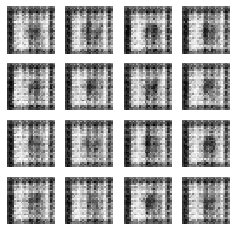

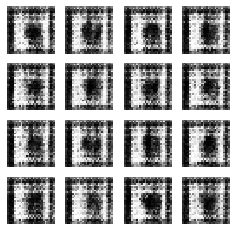

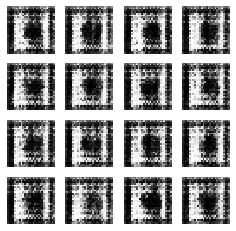

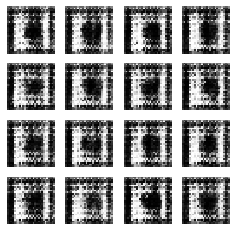

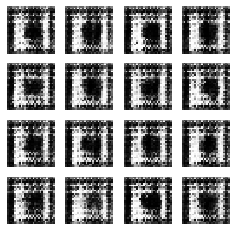

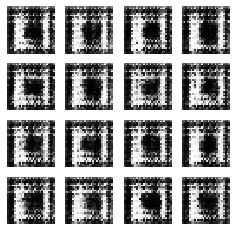

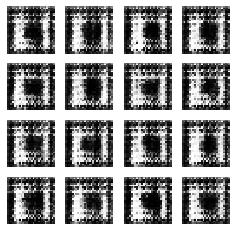

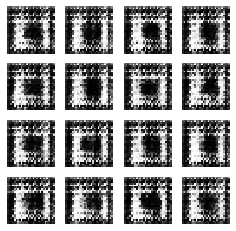

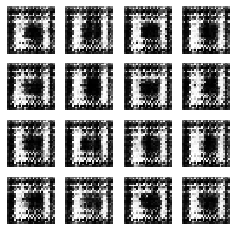

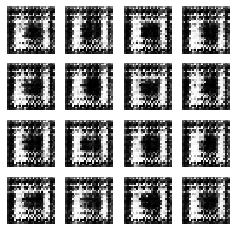



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [18]:
test_GAN(0)

Training GAN for Attack Class: 1
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


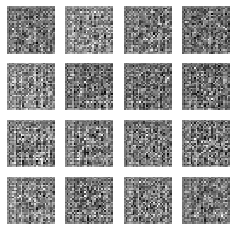

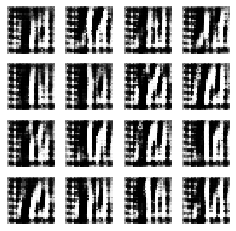

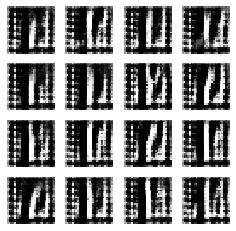

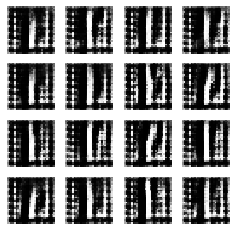

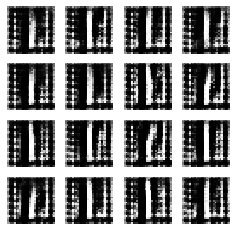

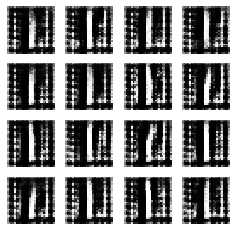

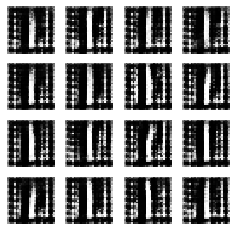

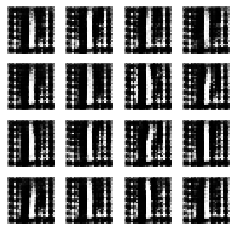

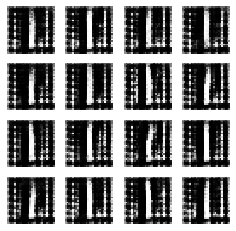

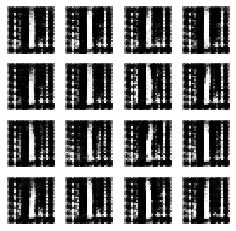



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [19]:
test_GAN(1)

Training GAN for Attack Class: 2
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


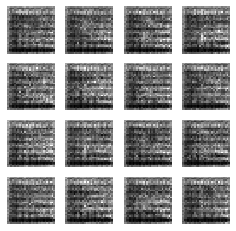

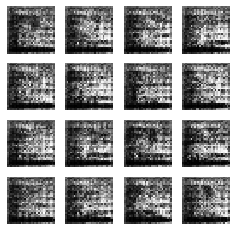

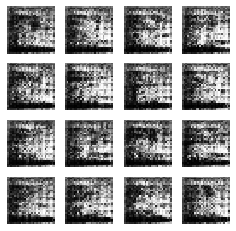

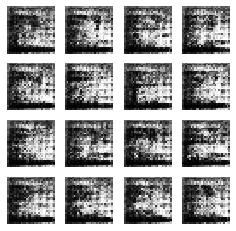

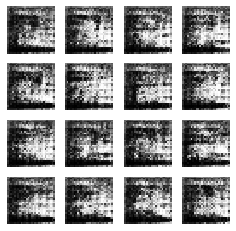

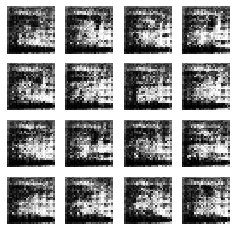

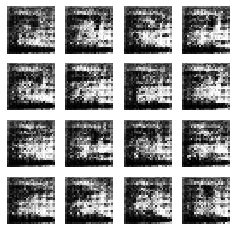

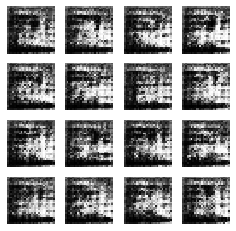

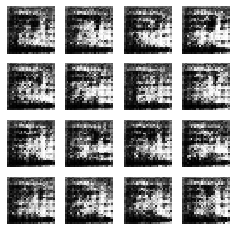

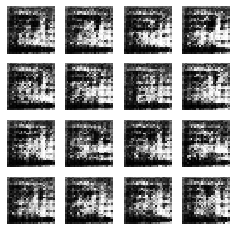



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [20]:
test_GAN(2)

Training GAN for Attack Class: 3
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


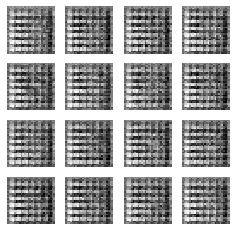

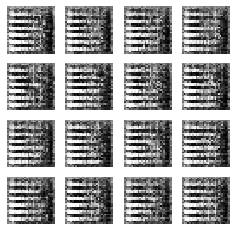

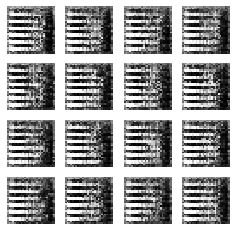

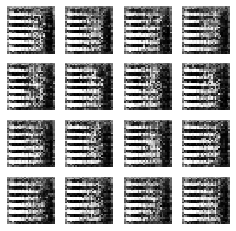

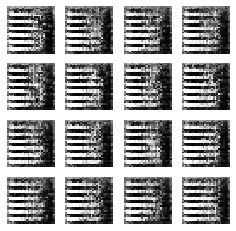

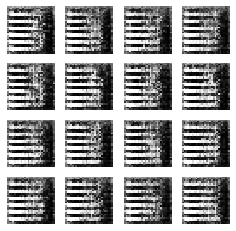

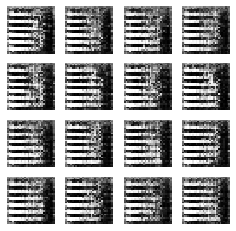

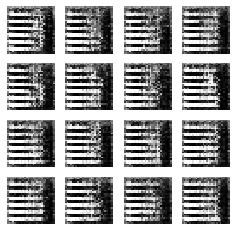

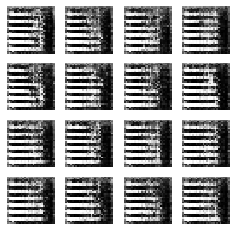

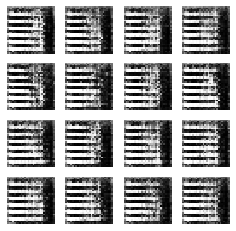



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [21]:
test_GAN(3)

Training GAN for Attack Class: 4
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


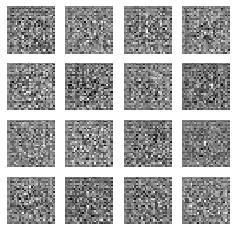

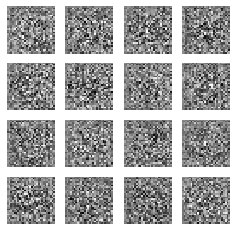

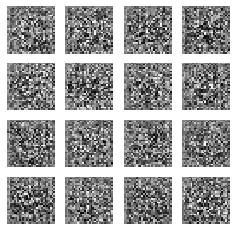

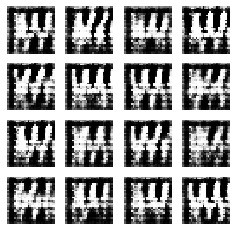

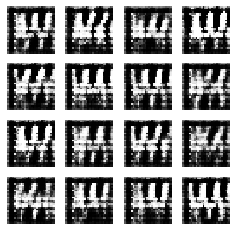

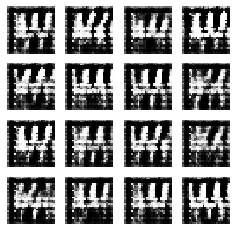

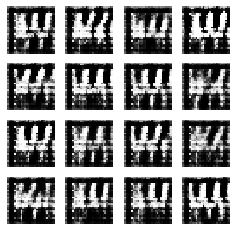

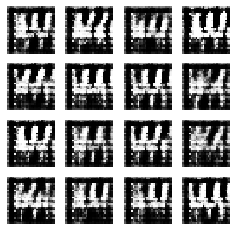

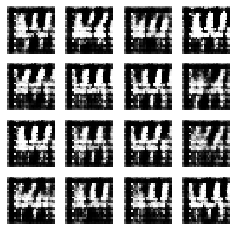

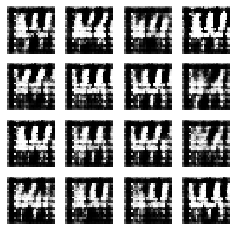



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [22]:
test_GAN(4)

Training GAN for Attack Class: 5
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


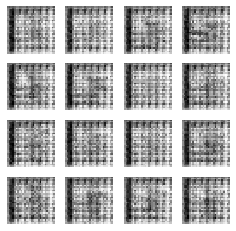

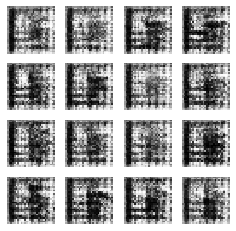

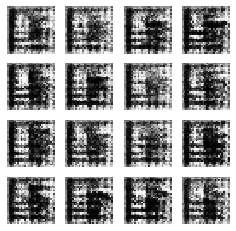

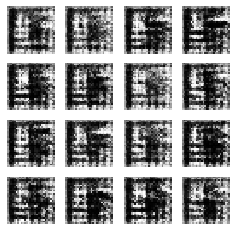

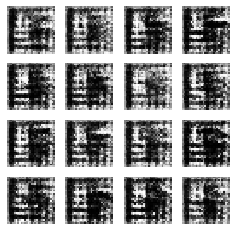

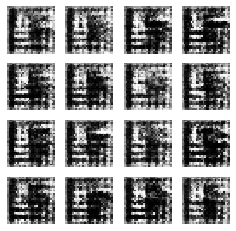

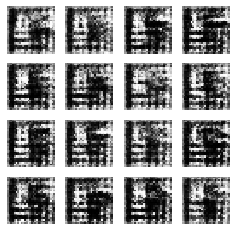

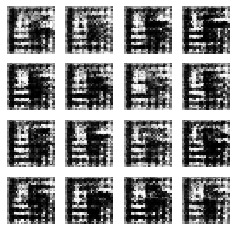

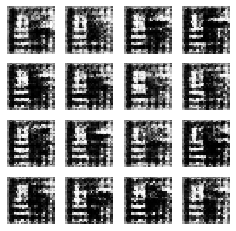

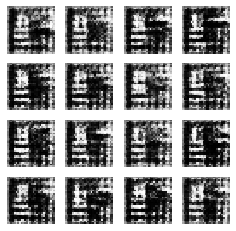



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [23]:
test_GAN(5)

Training GAN for Attack Class: 6
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


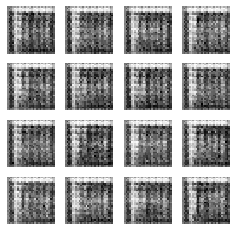

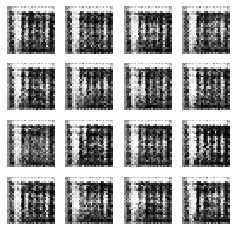

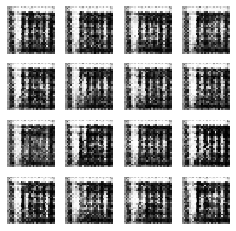

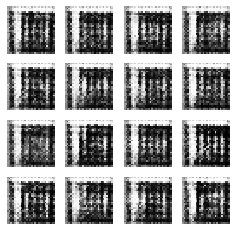

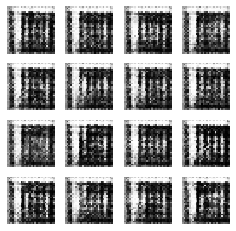

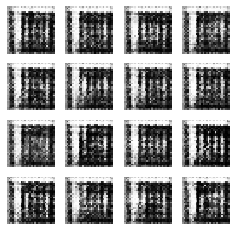

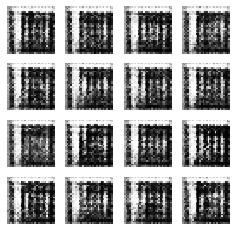

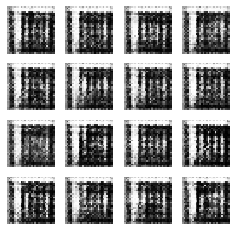

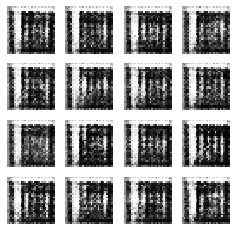

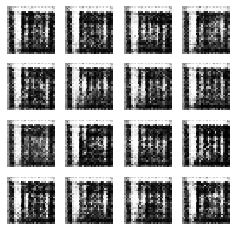



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [24]:
test_GAN(6)

Training GAN for Attack Class: 7
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


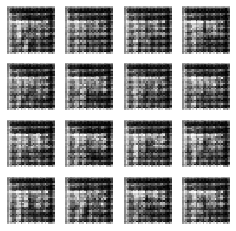

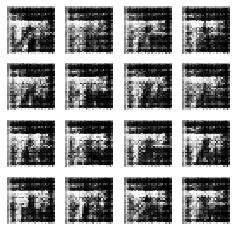

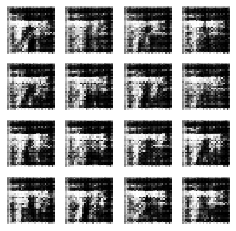

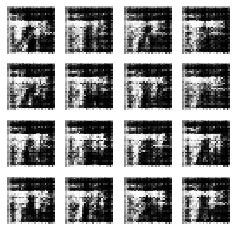

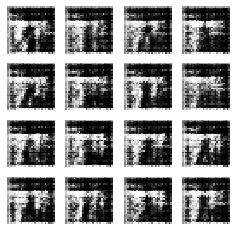

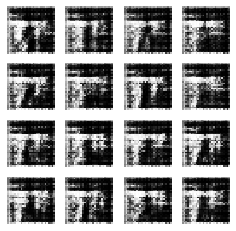

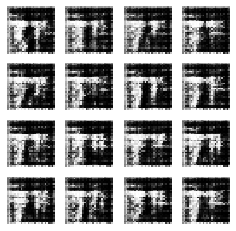

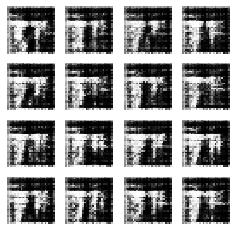

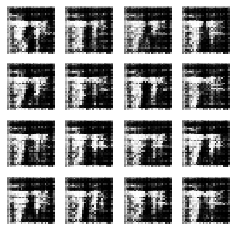

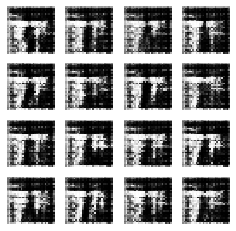



Double checking that the D in the GAN has been changed:
Test Accuracy: 0.762 | Loss: 0.678




In [25]:
test_GAN(7)

Training GAN for Attack Class: 8
Restored latest checkpoint from checkpoints\default\blackbox_checkpoint
No weights found at: checkpoints\it_0\discriminator_checkpoint
No weights found at: checkpoints\it_0\generator_checkpoint

Double checking that the D in the GAN has been trained:
Test Accuracy: 0.762 | Loss: 0.678


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training GAN


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


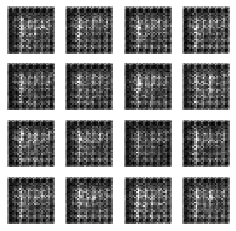

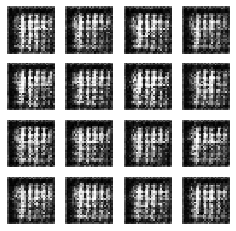

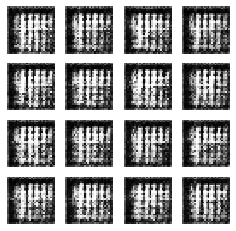

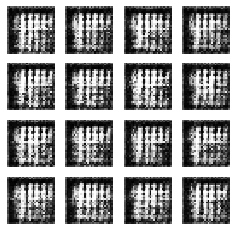

KeyboardInterrupt: 

In [26]:
test_GAN(8)

In [ ]:
test_GAN(9)